<a href="https://colab.research.google.com/github/yqwang01/COMPSCI526Project4-CovidEffects/blob/main/cluster2school.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 1. 加载数据
data = pd.read_excel('/content/drive/MyDrive/COMPSCI526/COVID-19-Constructed-Dataset-(PANEL).xlsx')

# 数据预处理：处理空值
data = data.dropna()

# 创建 'learning_mode' 列并数值化 (0 = in-person, 1 = online)
data['learning_mode'] = data['timeperiod'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# 创建 'score_mean' 列，计算每个学生的平均成绩
data['score_mean'] = data[['readingscore', 'writingscore', 'mathscore', 'readingscoreSL', 'writingscoreSL', 'mathscoreSL']].mean(axis=1)

data

,studentID,school,gradelevel,gender,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,readingscore,writingscore,mathscore,readingscoreSL,writingscoreSL,mathscoreSL,timeperiod,learning_mode,score_mean
0,1,0,6,1,1,59065.136719,0,5,3,1,0,73.393600,68.847290,86.905823,84.650970,83.348419,71.108353,2,0,78.042409
1,1,0,6,1,1,59065.136719,0,5,3,1,0,62.566071,73.258034,56.995117,77.571396,74.594040,57.717148,4,1,67.116968
2,1,0,6,1,1,59065.136719,0,5,3,1,0,79.965630,67.070084,56.612415,87.659691,80.292519,85.021355,1,0,76.103615
3,1,0,6,1,1,59065.136719,0,5,3,1,0,68.552406,55.633102,73.727753,69.650352,48.293591,86.596375,3,1,67.075596
4,1,0,6,1,1,59065.136719,0,5,3,1,0,82.541451,87.166336,65.315819,68.989784,85.802025,65.637871,0,0,75.908881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,1400,1,12,1,1,65783.632812,1,2,3,3,0,73.328003,67.402504,87.349442,70.828003,64.902504,84.849442,0,0,74.776649
8396,1400,1,12,1,1,65783.632812,1,2,3,3,3,58.969883,84.165405,64.040802,56.469883,81.665405,61.540802,2,0,67.808697
8397,1400,1,12,1,1,65783.632812,1,2,3,3,3,51.975296,82.905457,77.368134,49.475296,80.405457,74.868134,3,1,69.499629
8398,1400,1,12,1,1,65783.632812,1,2,3,3,3,64.103790,47.846565,81.086067,61.603794,45.346565,78.586067,1,0,63.095475


In [ ]:
# 1. 按 studentID 分组，并聚合不变的列
grouped_data = data.groupby('studentID').agg({
    'school': 'first',
    'gradelevel': 'first',
    'gender': 'first',
    'covidpos': 'first',
    'householdincome': 'first',
    'freelunch': 'first',
    'numcomputers': 'first',
    'familysize': 'first',
    'fathereduc': 'first',
    'mothereduc': 'first'
}).reset_index()

# 2. 计算 score_0 和 score_1 列
# 'score_0'：learning_mode = 0 时的 score_mean 平均值
# 'score_1'：learning_mode = 1 时的 score_mean 平均值
score_0 = data[data['learning_mode'] == 0].groupby('studentID')['score_mean'].mean().reset_index().rename(columns={'score_mean': 'score_0'})
score_1 = data[data['learning_mode'] == 1].groupby('studentID')['score_mean'].mean().reset_index().rename(columns={'score_mean': 'score_1'})

# 3. 合并 group_data 和 score_0, score_1
student = pd.merge(grouped_data, score_0, on='studentID', how='left')
student = pd.merge(student, score_1, on='studentID', how='left')

# 4. 创建新列 'score_change'，值为 'score_1 - score_0'
student['score_change'] = student['score_1'] - student['score_0']

student

,studentID,school,gradelevel,gender,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,score_0,score_1,score_change
0,1,0,6,1,1,59065.136719,0,5,3,1,0,76.684969,67.317394,-9.367575
1,2,0,6,1,1,107480.085938,1,4,1,1,1,77.301464,69.185421,-8.116043
2,3,0,6,1,0,79800.843750,1,0,2,1,1,80.267236,68.904894,-11.362342
3,4,0,6,1,1,125976.164062,1,2,3,1,2,85.052110,75.503005,-9.549105
4,5,0,6,0,1,110744.156250,1,5,2,0,1,80.709197,70.264784,-10.444413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1396,1,12,0,1,19891.384766,0,2,2,1,1,67.364002,61.226816,-6.137186
1396,1397,1,12,0,1,24009.490234,0,1,1,1,1,69.426918,55.967605,-13.459314
1397,1398,1,12,1,0,35121.308594,1,1,4,2,1,73.711424,69.846804,-3.864620
1398,1399,1,12,1,0,54383.433594,1,2,2,1,1,77.285325,67.355048,-9.930277



主成分 1: 解释方差比 = 0.2798
特征贡献: 
  gradelevel: 0.0142
  gender: 0.0246
  covidpos: -0.3016
  householdincome: 0.4796
  freelunch: 0.3045
  numcomputers: 0.3143
  familysize: -0.0252
  fathereduc: 0.0820
  mothereduc: 0.0263
  score_0: 0.4898
  score_1: 0.4885
  score_change: -0.0093

主成分 2: 解释方差比 = 0.1027
特征贡献: 
  gradelevel: -0.1078
  gender: -0.0464
  covidpos: 0.0713
  householdincome: 0.0015
  freelunch: 0.0345
  numcomputers: 0.0113
  familysize: 0.0227
  fathereduc: 0.1772
  mothereduc: -0.0817
  score_0: -0.2831
  score_1: 0.2956
  score_change: 0.8796

主成分 3: 解释方差比 = 0.0901
特征贡献: 
  gradelevel: 0.0911
  gender: 0.2919
  covidpos: 0.0450
  householdincome: -0.1148
  freelunch: -0.2716
  numcomputers: -0.1947
  familysize: -0.3450
  fathereduc: 0.6127
  mothereduc: 0.4979
  score_0: 0.1433
  score_1: 0.1260
  score_change: -0.0283

主成分 4: 解释方差比 = 0.0872
特征贡献: 
  gradelevel: 0.6407
  gender: 0.3581
  covidpos: 0.0519
  householdincome: 0.0051
  freelunch: 0.0517
  numcomputers: 0.068

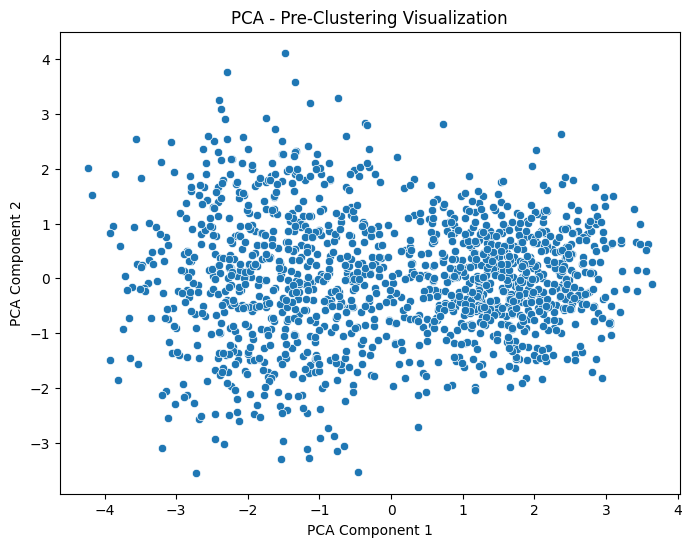

In [ ]:
# 2. 选择用于聚类的特征
features = [	'gradelevel' ,	'gender' ,	'covidpos', 	'householdincome' ,	'freelunch' ,	'numcomputers' ,	'familysize' ,	'fathereduc' ,	'mothereduc' ,	'score_0' ,	'score_1' ,	'score_change']
X = student[features]

# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA
import seaborn as sns

# 2. 应用 PCA
pca = PCA()
pca.fit(X_scaled)

# 3. 获取解释方差比
explained_variance_ratio = pca.explained_variance_ratio_

# 4. 获取主成分贡献矩阵（即每个主成分的特征系数）
components = pca.components_

# 5. 显示每个主成分的解释方差比和对应的特征
for i, (var_ratio, component) in enumerate(zip(explained_variance_ratio, components)):
    print(f"\n主成分 {i + 1}: 解释方差比 = {var_ratio:.4f}")
    print("特征贡献: ")
    for feature, coef in zip(features, component):
        print(f"  {feature}: {coef:.4f}")



# 1. PCA 降维到 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_scaled = X_pca

# 画 PCA 的二维散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1])
plt.title('PCA - Pre-Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

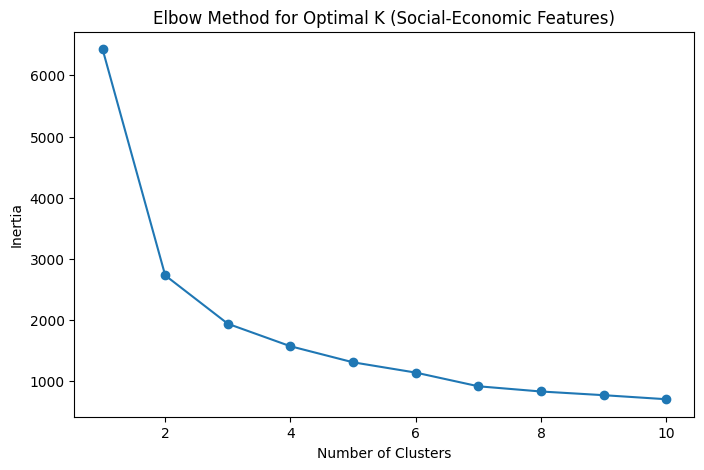

In [ ]:
# 4. 使用肘部法评估最佳聚类数
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 绘制肘部法图
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K (Social-Economic Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# 5. 应用 K-Means 聚类 (假设肘部法确定 k 为 2)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 将聚类结果加入数据框
student['cluster'] = clusters

# 6. 计算轮廓系数
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# 8. 对每个聚类组进行分析
cluster_analysis = student.groupby('cluster')[features].mean()
print("\nCluster Analysis (Mean Values per Cluster):")
print(cluster_analysis)

Silhouette Score: 0.5013465317573375

Cluster Analysis (Mean Values per Cluster):
         gradelevel    gender  covidpos  householdincome  freelunch  \
cluster                                                               
0          9.049157  0.539326  0.117978    114852.712962     1.0000   
1          8.949128  0.491279  0.552326     52661.598643     0.6875   

         numcomputers  familysize  fathereduc  mothereduc    score_0  \
cluster                                                                
0            3.136236    2.043539    1.356742    1.297753  82.987317   
1            1.482558    2.100291    1.289244    1.257267  71.459745   

           score_1  score_change  
cluster                           
0        74.938222     -8.049095  
1        63.607818     -7.851927  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE

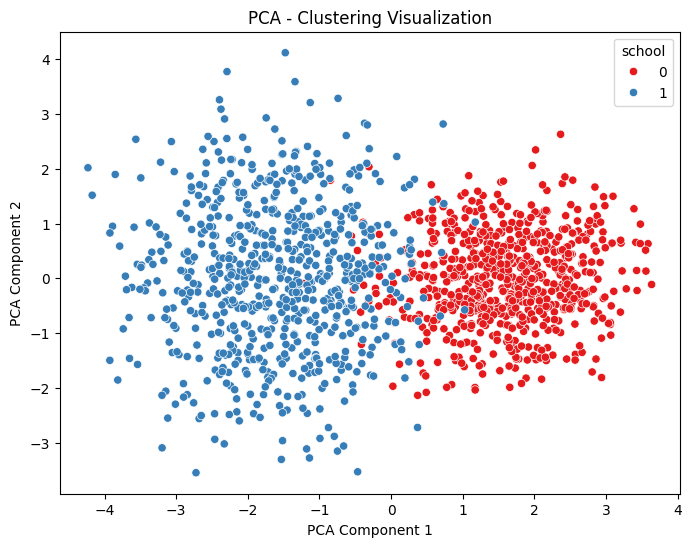

In [ ]:
# 1. PCA 降维到 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 画 PCA 的二维散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=student['school'], palette='Set1')
plt.title('PCA - Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

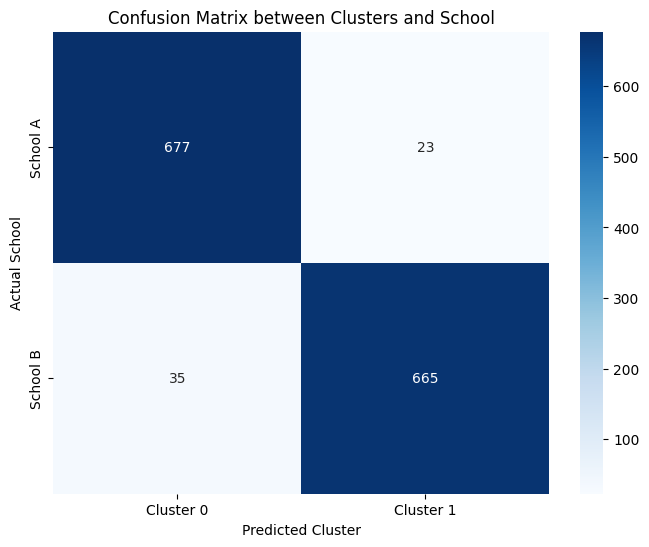

In [ ]:
from sklearn.metrics import confusion_matrix


# 1. 生成混淆矩阵
cm = confusion_matrix(student['school'], student['cluster'])

# 2. 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['School A', 'School B'])
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual School')
plt.title('Confusion Matrix between Clusters and School')
plt.show()
